# Vanishing

This jupyter notebook computes some vanishing results for the coherent cohomology of the Siegel variety in positive characteristic. Let $ p \geq 2$ be a prime number and $N \geq 3$ an integer such that $p \nmid N$. Let $X$ be a smooth and projective toroidal compactification of the Siegel variety of dimension $\frac{g(g+1)}{2}$ over $\mathbb{F}_p$. We denote by $D$ the border of the toroidal compactification. If $\lambda$ is a character of $\text{GL}_g$, then we denote by $\nabla(\lambda)$ the costandard automorphic vector bundle of highest weight $\lambda$. We implement an algorithm which computes characters $\lambda$ of $\text{GL}_g$ such that the coherent cohomology $H^i(X,\nabla(\lambda)(-D))$ vanishes.  

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt

class SiegelVariety:
    def __init__(self,g,p):
        self.g = g
        self.p = p
        self.d = g*(g+1)/2
        
        if g < 2:
            raise ValueError('The genus g must be greater than 1')
        elif p not in Primes():
            raise ValueError('The number ' + str(p) + ' is not prime')
        elif p < self.g**2:
            raise ValueError('The prime ' + str(p) + ' is lower than the dimension of the flag bundle ' + str(self.g**2))
        
        self.L = RootSystem("A"+str(self.g-1)).ambient_space() #Ag-1
        self.LG = RootSystem("C"+str(self.g)).ambient_space() #Cg
        self.W = WeylGroup(self.L)
        self.WG = WeylGroup(self.LG)

        A = WeylCharacterRing(['A',self.g-1])
        C = WeylCharacterRing(['C',self.g]) 
        self.phi_L = A.positive_roots()
        self.phi_G = C.positive_roots()
        self.Delta_L = A.simple_roots()
        self.Delta_G = C.simple_roots()

        #Cotangent bundle of the Siegel variety
        OmegaWeight = []
        for i in range(self.g):
            if i == 0:
                OmegaWeight.append(2)
            else:
                OmegaWeight.append(0)
        Omega1 = A(OmegaWeight)
        
        #Exterior product of differentials over the Siegel variety
        self.nu = []
        for i in range(1,self.d+1):
            temp = []
            Omega = Omega1.exterior_power(i)
            for x in Omega.weight_multiplicities():
                temp.append(x)
            self.nu.append(temp)
        
        self.mu = []
        for nu_j in self.nu:
            temp = []
            for char in nu_j:
                temp.append(self.L(self.changeConvention(char)))
            self.mu.append(temp)
            
        #Known vanishing results - in degrees i>k for k = 0 to d-1
        self.Cvan = []
        for i in range(self.d):
            self.Cvan.append([])
    
    #Change root convention
    def changeConvention(self,char):
        res = []
        for i in range(self.g-1,-1,-1):
            res.append(-char[i])
        return res
    
    #Test equality of characters
    def equality(self,el1,el2):
        for i in range(self.g):
            if el1[i] != el2[i]:
                return False
        return True
    
    #Create a list of subsets of given cardinal
    def powerset_length(self,s,n):
        res = []
        x = len(s)
        for i in range(1 << x):
            temp = []
            temp = [s[j] for j in range(x) if (i & (1 << j))]
            if len(temp) == n:
                res.append(temp)
        return res
        
    #Test if a list contains an element
    def contains(self,lst,el):
        for x in lst:
            if self.equality(x,el):
                return True
        return False
    
    #Test our vanishing result
    def vanishes(self,k, char):
        return self.contains(self.Cvan[k],char)
    
    #Construct relevant set of roots
    def buildIprime(self,T):
        Iprime = []
        for i in range(1,len(T)+1):
            if T[i-1] != 0:
                Iprime.append(self.Delta_L[i])
        return Iprime
    
    def buildRoots(self,Iprime):
        phi_Iprime = []
        phiLIprime = []
        for i in range(1 << len(Iprime)):
            temp = sum(Iprime[j] for j in range(len(Iprime)) if (i & (1 << j)))
            if temp != 0:
                tempList = []
                for k in range(self.g):
                    tempList.append(temp[k])
                if self.LG(tempList) in self.phi_G:
                    phi_Iprime.append(temp)
        for x in self.phi_L:
            if x not in phi_Iprime:
                phiLIprime.append(x)
        return phi_Iprime,phiLIprime
    
    #Check L_Iprime-dominance of characters
    def LIprimedominant(self,Iprime,phiLIprime,char):
        for alpha in phiLIprime:
            value = 0
            for j in range(self.g):
                value += char[j]*alpha[j]
            if value < 0:
                return False
        for alpha in Iprime:
            value = 0
            for j in range(self.g):
                value += char[j]*alpha[j]
            if value != 0:
                return False
        return True
    
    #Check L-dominance
    def Ldominant(self,char):
        for alpha in self.Delta_L:
            value = 0
            for j in range(self.g):
                value += char[j]*alpha[j]
            if value < 0:
                return False
        return True
    
    #Construction of a set of dominant weights between kmin and kmax 
    def buildWeights(self,kmin,kmax):
        kvalues = []
        kvalue = []
        for i in range(self.g):
            kvalue.append(kmin)
        stop = False
        stopGlobal = False
        icurrent = 0
        while not stopGlobal:
            stop = False
            kvaluetemp = kvalue.copy()
            kvalues.append(kvaluetemp)
            while not stop:
                if kvalue[icurrent] < kmax:
                    kvalue[icurrent] += 1
                    icurrent = 0
                    stop = True
                elif icurrent < self.g-1:
                    found = False
                    nextValue = 0
                    i = icurrent+1
                    while not found and i < self.g:
                        if kvalue[i] < kmax:
                            nextValue = kvalue[i]+1
                            found = True
                        i+=1
                    if found:
                        kvalue[icurrent] = nextValue
                        icurrent += 1
                    else:
                        stop = True
                        stopGlobal = True
                else:
                    stop = True
                    stopGlobal = True
        return kvalues
    
    #If it returns True, it means that the automorphic line bundle of weight char
    #is D-ample on the flag bundle of type Iprime
    def ample(self,Iprime,char):
        for w in self.WG:
            for alpha in self.phi_G:
                alpha = alpha.associated_coroot()
                v = w.action(alpha)
                num = 0
                for j in range(self.g):
                    num += char[j]*v[j]
                den = 0
                for j in range(self.g):
                    den += char[j]*alpha[j]
                if den != 0:
                    if max(num/den,-num/den) > self.p-1:
                        return False
        for alpha in self.phi_G:
            if not self.contains(self.phi_L,alpha):
                alpha = alpha.associated_coroot()
                value = 0
                for j in range(self.g):
                    value += char[j]*alpha[j]
                if value >= 0:
                    return False
        for alpha in self.Delta_L:
            if alpha not in Iprime:
                value = 0
                for j in range(self.g):
                    value += char[j]*alpha[j]
                if value <= 0:
                    return False
        return True

    #Check a partial degeneration of a spectral sequence
    def degeneration(self,Iprime,phiLIprime,tworhoIprime,e,char):
        lamb = self.L(char)
        lambp = lamb-self.mu[self.d-e-1][0]
        r = len(phiLIprime)
        if self.LIprimedominant(Iprime,phiLIprime,lambp) and self.ample(Iprime,lambp+tworhoIprime):
            for k in range(e+1):
                set_of_M = self.powerset_length(phiLIprime,r-k)
                for M in set_of_M:
                    if len(M) != 0:
                        s_M = sum(M)
                        for j in range(0,len(self.mu[self.d-e+k-1])):
                            if k!=0 or j != 0:
                                if e+1 < self.d:
                                    value = lambp - s_M +tworhoIprime+self.mu[self.d-e+k-1][j]
                                    if self.Ldominant(value) and value not in self.Cvan[e+1]:
                                        return False
            return True
        else:
            return False
        
    #Compute a set of vanishing results from the flag bundle of type Iprime
    #for degrees > e and between kmin and kmax
    def compute(self,T,e,kmin,kmax):
        res = False
        Iprime = self.buildIprime(T)
        phi_Iprime, phiLIprime = self.buildRoots(Iprime)
        tworhoIprime = sum(x for x in phiLIprime)
        kvalues = self.buildWeights(kmin,kmax)
        timer = tqdm(kvalues)
        for char in timer:
            if not self.contains(self.Cvan[e],self.L(char)):
                if self.degeneration(Iprime,phiLIprime,tworhoIprime,e,char):
                    res = True
                    for k in range(e,self.d):
                        self.Cvan[k].append(self.L(char))
        return res
    
    #Compute a set of vanishing results between kmin and kmax
    def computeAll(self,kmin,kmax):
        out = False
        Iprimes = []
        for i in range(1 << self.g-1):
            T = [0 for i in range(self.g-1)]
            for j in range(self.g-1):
                if (i & (1 << j)):
                    T[j] = 1
            Iprimes.append(T)
        step = 1
        max_step = len(Iprimes)*(self.d)
        for T in Iprimes:
            for e in range(self.d):
                print('Step '+str(step)+'/'+str(max_step)+' : e = '+str(e)+', Iprime = '+str(T))
                res = self.compute(T,e,kmin,kmax)
                out = out or res 
                step = step +1
        return out
        
    #Technical conversion of the set of vanishing results
    def convert(self):
        res = []
        added = []
        for c in self.Cvan:
            a = []
            for x in c:
                if x not in added:
                    b = []
                    for i in range(self.g):
                        b.append(x[i])
                    a.append(b)
                    added.append(x)
            res.append(a)
        return res
    
    #Save vanishing results in a file
    def save(self):
        res = self.convert()
        for k in range(self.d):
            filepath = 'g'+str(self.g)+'p'+str(self.p)+'_'+str(k)+'.txt'
            with open('save/'+filepath,'w') as f:
                for item in res[k]:
                    for x in item:
                        f.write("%s " % x)
                    f.write("\n")
                print('Results saved in '+filepath)
    
    #Load vanishing results from a file
    def load(self):
        for k in range(self.d):
            filepath = 'g'+str(self.g)+'p'+str(self.p)+'_'+str(k)+'.txt'
            with open('save/'+filepath,'r') as f:
                data = f.read()
                list_data = data.split('\n')
                chars = []
                for x in list_data:       
                    y = x.split(' ')
                    y.pop()
                    char = [int(z) for z in y]
                    if len(char) == self.g:
                        chars.append(char)
                for i in range(k,self.d):
                    for char in chars:
                        if not self.vanishes(i,char):
                            self.Cvan[i].append(char)
                print('Results loaded from '+filepath)
                
    #Get statistics about the results
    def statistics(self):
        res = self.convert()
        for i in range(self.d):
            print('H^* is concentrated in degrees [0:' + str(i) + '] for ' + str(len(res[i])) + ' characters')
            
    #Get psmall weights for Sp_2g twisted by -w0
    def psmall(self,kmax):
        kmin = 0
        kvalues = self.buildWeights(kmin,kmax)
        rho = 1/2*sum(self.phi_G)
        res = []
        for char in kvalues:
            is_psmall = True
            for alpha in self.phi_G:
                prod = 0
                for j in range(self.g):
                    prod += (char[j]+rho[j])*alpha[j]
                if max(prod,-prod) > self.p:
                    is_psmall = False
                    break
            if is_psmall:
                res += [tuple(self.changeConvention(char))]
        filepath = 'g'+str(self.g)+'p'+str(self.p)+'_psmall'+'.txt'
        with open('save/'+filepath,'w') as f:
                for char in res:
                    for x in char:
                        f.write("%s " % x)
                    f.write("\n")
        print('p-small weights saved in '+filepath)
        print(res)

# Basic use examples

We create the Siegel threefold $X$ over $\mathbb{F}_7$.

In [3]:
X = SiegelVariety(g = 2, p = 7)

If the next line returns True, it means that the automorphic line bundle $\mathcal{L}_{(-2,-8)}$ is $D$-ample on the complete flag variety $Y$ over $X$.

In [4]:
X.ample([],[-2,-8])

True

The next line compute vanishing results for characters $\lambda = (k_1,k_2)$ with $ -50 \leq k_2 \leq k_1 \leq 0$ using the function $g_{I_0,e}$ in the case where $I_0 = \emptyset$ and $e = 0$. The results are registered in the list $C_{\text{van}}$. It returns True if the algorithm has found new vanishing results.

In [5]:
X.compute([], e = 0, kmin = -50, kmax = 0)

100%|██████████| 1326/1326 [00:01<00:00, 944.61it/s]


True

The next line runs the compute method for each $I_0 \subset I$ and $0 \leq e \leq d$. We only need to specify the range of characters $\lambda = (k_1,k_2)$ we want to consider. It returns True if the algorithm has found new vanishing results. You may want to run this command several times until it returns False.

In [6]:
X.computeAll(-50,0)

Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:00<00:00, 2175.40it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:00<00:00, 2173.92it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:00<00:00, 2344.30it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 4607.75it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 4322.07it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 4862.52it/s]


True

The next line returns True if we know that $H^i(X,\nabla(-4,-6)(-D)) = 0$ for all $i>1$.

In [7]:
X.vanishes(1,(-4,-6))

True

If the next line returns False, it means we don't know if $H^i(X,\nabla(-4,-6)(-D)) = 0$ for all $i>0$.

In [8]:
X.vanishes(0,(-4,-6))

False

In [9]:
X.statistics()

H^* is concentrated in degrees [0:0] for 691 characters
H^* is concentrated in degrees [0:1] for 88 characters
H^* is concentrated in degrees [0:2] for 77 characters


# Save/Load results

In [11]:
X.save()

Results saved in g2p7_0.txt
Results saved in g2p7_1.txt
Results saved in g2p7_2.txt


In [10]:
X.load()

Results loaded from g2p7_0.txt
Results loaded from g2p7_1.txt
Results loaded from g2p7_2.txt


# Other computations

We compute and save vanishing results for different values of $p$ when $g = 2$

In [20]:
p_values = [5,7,11,31]
for p in p_values:
    X_p = SiegelVariety(g = 2, p = p)
    found = True
    while found:
        found = X_p.computeAll(-50,0)
    X_p.save()

Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 1202.76it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:00<00:00, 1343.47it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:00<00:00, 1372.53it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 12987.16it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 14297.84it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 15776.51it/s]


Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 1247.64it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 1260.38it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:00<00:00, 1344.22it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 12942.52it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 14209.15it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 15785.87it/s]


Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 1209.52it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 1266.19it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 1242.79it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 12781.84it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 13924.48it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 15524.79it/s]


Results saved in g2p5_0.txt
Results saved in g2p5_1.txt
Results saved in g2p5_2.txt
Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 897.25it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 1025.56it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 952.47it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 7361.36it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 10942.03it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 9952.93it/s] 


Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 811.62it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 910.85it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 1014.88it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 10650.33it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 12037.70it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 13883.19it/s]


Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 890.31it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 956.14it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 1067.25it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 11780.38it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 13304.96it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 14974.78it/s]


Results saved in g2p7_0.txt
Results saved in g2p7_1.txt
Results saved in g2p7_2.txt
Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 726.84it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 801.21it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 878.43it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 10365.61it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 12787.16it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 14485.15it/s]


Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 732.81it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 801.25it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 882.37it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 10582.69it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 12489.64it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 14808.20it/s]


Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 735.99it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 776.45it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 887.72it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 11182.52it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 12850.86it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 15088.08it/s]


Results saved in g2p11_0.txt
Results saved in g2p11_1.txt
Results saved in g2p11_2.txt
Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:02<00:00, 593.98it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:02<00:00, 644.37it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 720.97it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 10189.02it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 12642.06it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 14879.11it/s]


Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:02<00:00, 570.79it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:02<00:00, 619.77it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 739.73it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 10738.93it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 13718.20it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 15584.26it/s]


Step 1/6 : e = 0, Iprime = [0]


100%|██████████| 1326/1326 [00:02<00:00, 588.71it/s]


Step 2/6 : e = 1, Iprime = [0]


100%|██████████| 1326/1326 [00:02<00:00, 645.53it/s]


Step 3/6 : e = 2, Iprime = [0]


100%|██████████| 1326/1326 [00:01<00:00, 750.06it/s]


Step 4/6 : e = 0, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 10039.15it/s]


Step 5/6 : e = 1, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 13304.39it/s]


Step 6/6 : e = 2, Iprime = [1]


100%|██████████| 1326/1326 [00:00<00:00, 15327.00it/s]


Results saved in g2p31_0.txt
Results saved in g2p31_1.txt
Results saved in g2p31_2.txt


We compute and save vanishing results for different values of $p$ when $g = 3$

In [13]:
p_values = [11,31,691]
for p in p_values:
    X_p = SiegelVariety(g = 3, p = p)
    i = 2
    while i>0:
        X_p.computeAll(-25,0)
        i -= 1
    X_p.save()

Step 1/24 : e = 0, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:33<00:00, 96.98it/s] 


Step 2/24 : e = 1, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:19<00:00, 170.04it/s]


Step 3/24 : e = 2, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:16<00:00, 203.75it/s]


Step 4/24 : e = 3, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:16<00:00, 198.22it/s]


Step 5/24 : e = 4, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:15<00:00, 212.70it/s]


Step 6/24 : e = 5, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:16<00:00, 194.69it/s]


Step 7/24 : e = 0, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:05<00:00, 614.75it/s]


Step 8/24 : e = 1, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 1022.08it/s]


Step 9/24 : e = 2, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1170.75it/s]


Step 10/24 : e = 3, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1197.01it/s]


Step 11/24 : e = 4, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 845.96it/s] 


Step 12/24 : e = 5, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1125.25it/s]


Step 13/24 : e = 0, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:05<00:00, 572.83it/s]


Step 14/24 : e = 1, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 1032.15it/s]


Step 15/24 : e = 2, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:04<00:00, 755.38it/s]


Step 16/24 : e = 3, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 1053.46it/s]


Step 17/24 : e = 4, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 998.26it/s] 


Step 18/24 : e = 5, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 964.70it/s] 


Step 19/24 : e = 0, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2712.12it/s]


Step 20/24 : e = 1, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2899.45it/s]


Step 21/24 : e = 2, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2635.12it/s]


Step 22/24 : e = 3, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2891.09it/s]


Step 23/24 : e = 4, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2580.97it/s]


Step 24/24 : e = 5, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2226.79it/s]


Step 1/24 : e = 0, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:21<00:00, 151.16it/s]


Step 2/24 : e = 1, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:17<00:00, 185.46it/s]


Step 3/24 : e = 2, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:15<00:00, 215.76it/s]


Step 4/24 : e = 3, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:15<00:00, 211.43it/s]


Step 5/24 : e = 4, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:14<00:00, 219.07it/s]


Step 6/24 : e = 5, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:08<00:00, 368.00it/s]


Step 7/24 : e = 0, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 1086.79it/s]


Step 8/24 : e = 1, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 1042.03it/s]


Step 9/24 : e = 2, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1118.29it/s]


Step 10/24 : e = 3, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1141.67it/s]


Step 11/24 : e = 4, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 973.62it/s] 


Step 12/24 : e = 5, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1573.18it/s]


Step 13/24 : e = 0, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 982.11it/s] 


Step 14/24 : e = 1, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 1065.04it/s]


Step 15/24 : e = 2, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:04<00:00, 781.97it/s] 


Step 16/24 : e = 3, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 1067.06it/s]


Step 17/24 : e = 4, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 1030.89it/s]


Step 18/24 : e = 5, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:02<00:00, 1398.22it/s]


Step 19/24 : e = 0, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 3169.45it/s]


Step 20/24 : e = 1, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2882.48it/s]


Step 21/24 : e = 2, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2864.47it/s]


Step 22/24 : e = 3, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2830.98it/s]


Step 23/24 : e = 4, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2768.96it/s]


Step 24/24 : e = 5, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2149.89it/s]


Results saved in g3p11_0.txt
Results saved in g3p11_1.txt
Results saved in g3p11_2.txt
Results saved in g3p11_3.txt
Results saved in g3p11_4.txt
Results saved in g3p11_5.txt
Step 1/24 : e = 0, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:56<00:00, 58.19it/s]


Step 2/24 : e = 1, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:28<00:00, 114.31it/s]


Step 3/24 : e = 2, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:23<00:00, 137.34it/s]


Step 4/24 : e = 3, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:24<00:00, 135.19it/s]


Step 5/24 : e = 4, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:24<00:00, 134.98it/s]


Step 6/24 : e = 5, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:26<00:00, 121.93it/s]


Step 7/24 : e = 0, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 841.85it/s] 


Step 8/24 : e = 1, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 932.57it/s] 


Step 9/24 : e = 2, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 966.40it/s] 


Step 10/24 : e = 3, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 968.04it/s] 


Step 11/24 : e = 4, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 856.98it/s] 


Step 12/24 : e = 5, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1159.26it/s]


Step 13/24 : e = 0, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 839.20it/s] 


Step 14/24 : e = 1, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 927.50it/s] 


Step 15/24 : e = 2, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 955.89it/s] 


Step 16/24 : e = 3, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 945.32it/s] 


Step 17/24 : e = 4, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 943.48it/s] 


Step 18/24 : e = 5, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:02<00:00, 1152.98it/s]


Step 19/24 : e = 0, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2498.30it/s]


Step 20/24 : e = 1, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2304.66it/s]


Step 21/24 : e = 2, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2278.77it/s]


Step 22/24 : e = 3, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2296.33it/s]


Step 23/24 : e = 4, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2221.04it/s]


Step 24/24 : e = 5, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 1865.95it/s]


Step 1/24 : e = 0, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:33<00:00, 96.78it/s] 


Step 2/24 : e = 1, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:26<00:00, 125.84it/s]


Step 3/24 : e = 2, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:22<00:00, 147.35it/s]


Step 4/24 : e = 3, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:22<00:00, 142.87it/s]


Step 5/24 : e = 4, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:23<00:00, 141.05it/s]


Step 6/24 : e = 5, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:15<00:00, 215.11it/s]


Step 7/24 : e = 0, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 923.20it/s] 


Step 8/24 : e = 1, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 909.98it/s] 


Step 9/24 : e = 2, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 894.69it/s] 


Step 10/24 : e = 3, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 911.31it/s] 


Step 11/24 : e = 4, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 1037.24it/s]


Step 12/24 : e = 5, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1285.87it/s]


Step 13/24 : e = 0, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 843.43it/s] 


Step 14/24 : e = 1, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 994.20it/s] 


Step 15/24 : e = 2, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 1026.47it/s]


Step 16/24 : e = 3, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 1002.91it/s]


Step 17/24 : e = 4, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 990.82it/s] 


Step 18/24 : e = 5, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:02<00:00, 1125.36it/s]


Step 19/24 : e = 0, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2524.59it/s]


Step 20/24 : e = 1, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2276.51it/s]


Step 21/24 : e = 2, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2307.95it/s]


Step 22/24 : e = 3, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2267.72it/s]


Step 23/24 : e = 4, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2210.64it/s]


Step 24/24 : e = 5, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 1837.57it/s]


Results saved in g3p31_0.txt
Results saved in g3p31_1.txt
Results saved in g3p31_2.txt
Results saved in g3p31_3.txt
Results saved in g3p31_4.txt
Results saved in g3p31_5.txt
Step 1/24 : e = 0, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:56<00:00, 57.82it/s]


Step 2/24 : e = 1, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:28<00:00, 114.04it/s]


Step 3/24 : e = 2, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:23<00:00, 136.55it/s]


Step 4/24 : e = 3, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:24<00:00, 134.04it/s]


Step 5/24 : e = 4, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:24<00:00, 135.72it/s]


Step 6/24 : e = 5, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:26<00:00, 122.25it/s]


Step 7/24 : e = 0, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 845.46it/s] 


Step 8/24 : e = 1, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 939.14it/s] 


Step 9/24 : e = 2, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 970.35it/s] 


Step 10/24 : e = 3, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 970.20it/s] 


Step 11/24 : e = 4, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 864.97it/s] 


Step 12/24 : e = 5, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1141.14it/s]


Step 13/24 : e = 0, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 838.03it/s] 


Step 14/24 : e = 1, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 939.68it/s] 


Step 15/24 : e = 2, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 943.47it/s] 


Step 16/24 : e = 3, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 950.59it/s] 


Step 17/24 : e = 4, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 923.78it/s] 


Step 18/24 : e = 5, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:02<00:00, 1162.05it/s]


Step 19/24 : e = 0, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2484.47it/s]


Step 20/24 : e = 1, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2308.34it/s]


Step 21/24 : e = 2, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2284.62it/s]


Step 22/24 : e = 3, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2282.88it/s]


Step 23/24 : e = 4, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2207.21it/s]


Step 24/24 : e = 5, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 1873.80it/s]


Step 1/24 : e = 0, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:33<00:00, 97.50it/s] 


Step 2/24 : e = 1, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:26<00:00, 122.85it/s]


Step 3/24 : e = 2, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:22<00:00, 143.65it/s]


Step 4/24 : e = 3, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:23<00:00, 138.58it/s]


Step 5/24 : e = 4, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:23<00:00, 139.82it/s]


Step 6/24 : e = 5, Iprime = [0, 0]


100%|██████████| 3276/3276 [00:15<00:00, 215.56it/s]


Step 7/24 : e = 0, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 924.45it/s] 


Step 8/24 : e = 1, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 928.72it/s] 


Step 9/24 : e = 2, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 960.05it/s] 


Step 10/24 : e = 3, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 951.47it/s] 


Step 11/24 : e = 4, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:03<00:00, 1020.05it/s]


Step 12/24 : e = 5, Iprime = [1, 0]


100%|██████████| 3276/3276 [00:02<00:00, 1276.21it/s]


Step 13/24 : e = 0, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 840.64it/s] 


Step 14/24 : e = 1, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 992.17it/s] 


Step 15/24 : e = 2, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 1025.72it/s]


Step 16/24 : e = 3, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 1013.61it/s]


Step 17/24 : e = 4, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:03<00:00, 997.35it/s] 


Step 18/24 : e = 5, Iprime = [0, 1]


100%|██████████| 3276/3276 [00:02<00:00, 1135.86it/s]


Step 19/24 : e = 0, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2515.19it/s]


Step 20/24 : e = 1, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2261.86it/s]


Step 21/24 : e = 2, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2278.99it/s]


Step 22/24 : e = 3, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2260.76it/s]


Step 23/24 : e = 4, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 2200.22it/s]


Step 24/24 : e = 5, Iprime = [1, 1]


100%|██████████| 3276/3276 [00:01<00:00, 1829.53it/s]


Results saved in g3p691_0.txt
Results saved in g3p691_1.txt
Results saved in g3p691_2.txt
Results saved in g3p691_3.txt
Results saved in g3p691_4.txt
Results saved in g3p691_5.txt


We compute and save some $\text{Sp}_{2g}$ p-small weights for different values of $p$ when $g = 2$ 

In [21]:
p_values = [5,7,11,31]
for p in p_values:
    X_p = SiegelVariety(g = 2, p = p)
    X_p.psmall(6*p)

p-small weights saved in g2p5_psmall.txt
[(0, 0)]
p-small weights saved in g2p7_psmall.txt
[(0, 0), (0, -1), (-1, -1)]
p-small weights saved in g2p11_psmall.txt
[(0, 0), (0, -1), (0, -2), (0, -3), (-1, -1), (-1, -2), (-1, -3), (-2, -2), (-2, -3), (-3, -3)]
p-small weights saved in g2p31_psmall.txt
[(0, 0), (0, -1), (0, -2), (0, -3), (0, -4), (0, -5), (0, -6), (0, -7), (0, -8), (0, -9), (0, -10), (0, -11), (0, -12), (0, -13), (-1, -1), (-1, -2), (-1, -3), (-1, -4), (-1, -5), (-1, -6), (-1, -7), (-1, -8), (-1, -9), (-1, -10), (-1, -11), (-1, -12), (-1, -13), (-2, -2), (-2, -3), (-2, -4), (-2, -5), (-2, -6), (-2, -7), (-2, -8), (-2, -9), (-2, -10), (-2, -11), (-2, -12), (-2, -13), (-3, -3), (-3, -4), (-3, -5), (-3, -6), (-3, -7), (-3, -8), (-3, -9), (-3, -10), (-3, -11), (-3, -12), (-3, -13), (-4, -4), (-4, -5), (-4, -6), (-4, -7), (-4, -8), (-4, -9), (-4, -10), (-4, -11), (-4, -12), (-4, -13), (-5, -5), (-5, -6), (-5, -7), (-5, -8), (-5, -9), (-5, -10), (-5, -11), (-5, -12), (-5, -13), (

# Plotting tools

In [ ]:
#Plot our results when g = 2 or g = 3
def plot(variety):
    colors = ['k','b','r','g','c']
    if variety.g == 2:
        res = variety.convert()
        plt.clf()
        fig = plt.figure(figsize=(12,6))
        for k in range(variety.d):
            if len(res[k]) != 0:
                x, y = zip(*res[k])
                plt.scatter(x,y, label='Concentrated in degrees [0 : ' + str(k) + ']' , color = colors[k%len(colors)])  
        plt.title('Vanishing results for Siegel threefold with p = ' + str(variety.p))
        plt.legend()
        plt.show()
    elif variety.g == 3:
        res = variety.convert()
        plt.clf()
        fig = plt.figure(figsize=(25,15))
        ax = plt.axes(projection='3d')
        for k in range(variety.d):
            if len(res[k]) != 0:
                x, y, z = zip(*res[k])
                ax.scatter3D(x,y,z, label='Concentrated in degrees [0 : ' + str(k) + ']' , color =  colors[k%len(colors)])  
        plt.title('Vanishing results for Siegel variety of genus 3 with p = ' + str(variety.p))
        plt.legend()
        plt.show() 
    else:
        print('The genus must be 2 or 3')

Results loaded from g2p11_0.txt
Results loaded from g2p11_1.txt
Results loaded from g2p11_2.txt


<Figure size 432x288 with 0 Axes>

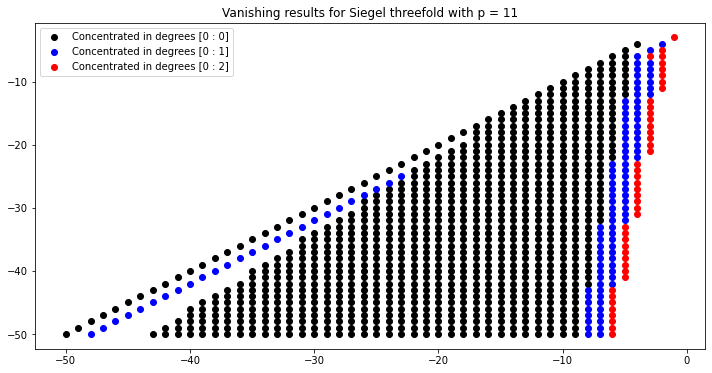

In [14]:
X = SiegelVariety(g = 2, p = 11)
X.load()
plot(X)

Results loaded from g3p11_0.txt
Results loaded from g3p11_1.txt
Results loaded from g3p11_2.txt
Results loaded from g3p11_3.txt
Results loaded from g3p11_4.txt
Results loaded from g3p11_5.txt


<Figure size 432x288 with 0 Axes>

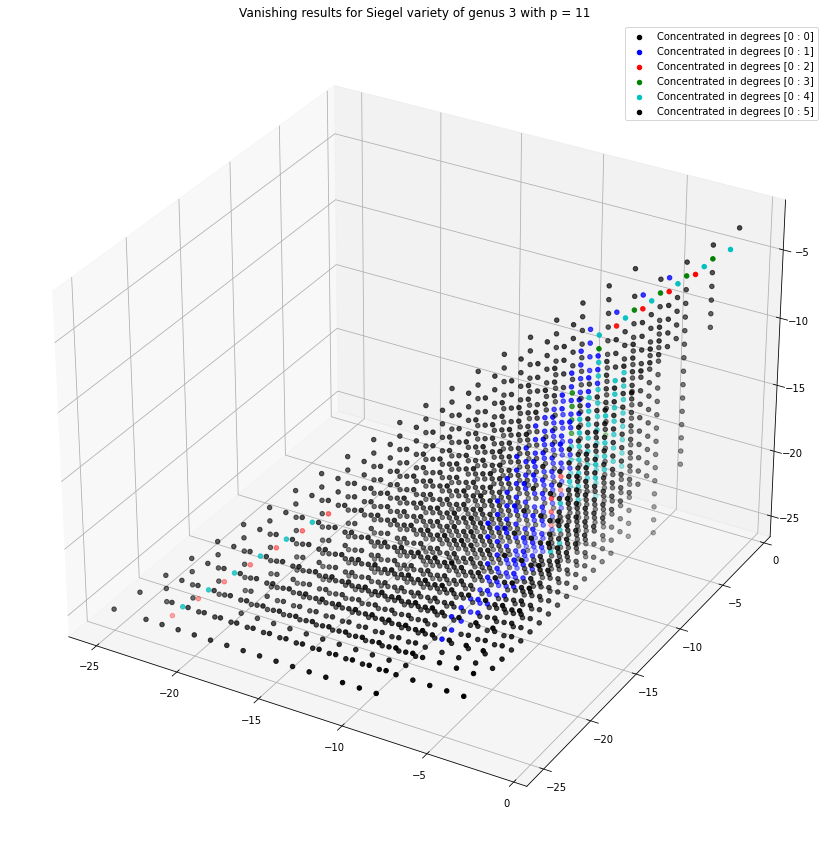

In [15]:
Y = SiegelVariety(g = 3, p = 11)
Y.load()
plot(Y)